# I. Import libraries and dataset 

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
import ta
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [2]:
MSN = pd.read_csv('../Datasets/MSN.csv')

# II. EDA 

## 1. Statistic

In [3]:
MSN

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0
...,...,...,...,...,...,...,...,...
135349,MSN,12/22/2020 14:23,82.8,82.8,82.8,82.8,700,0
135350,MSN,12/22/2020 14:24,82.7,82.8,82.7,82.8,4660,0
135351,MSN,12/22/2020 14:25,82.8,82.8,82.8,82.8,50,0
135352,MSN,12/22/2020 14:27,82.8,82.8,82.8,82.8,300,0


In [4]:
MSN.describe()

,Open,High,Low,Close,Volume,Open Interest
count,135354.000000,135354.000000,135354.000000,135354.000000,1.353540e+05,135354.0
mean,74.878809,74.931668,74.834625,74.880759,5.683578e+03,0.0
std,15.418074,15.426954,15.412677,15.418857,2.798513e+04,0.0
min,46.500000,46.500000,46.400000,46.400000,1.000000e+01,0.0
25%,57.900000,57.900000,57.800000,57.800000,5.000000e+02,0.0
50%,79.100000,79.200000,79.100000,79.100000,2.000000e+03,0.0
75%,86.000000,86.100000,86.000000,86.000000,5.560000e+03,0.0
max,117.800000,118.000000,117.700000,118.000000,3.300680e+06,0.0


- Dataset MSN gồm có 135354 samples, là các dữ liệu về giá OHLC, volumne, open interest của mã cổ phiếu MSN, được ghi nhận từ ngày 25/12/2017 đến 22/12/2020.
- Các giá trị đều nằm trong khoảng hợp lệ (không có giá trị nào âm).

In [5]:
MSN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [6]:
MSN.duplicated().sum()

0

- Dataset khá clean khi không có missing và duplicated value.
- Tuy nhiên các mốc thời gian ghi nhận trong dataset lại rời rạc và chỉ ghi nhận một vài thời điểm trong ngày.

## 2. Close price visualization

- Dataset sẽ được gộp lại, thành ghi nhận theo ngày.

In [7]:
from preprocessing import aggregate_intraday_to_daily

In [8]:
MSN = aggregate_intraday_to_daily(MSN)

In [9]:
MSN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    748 non-null    object 
 1   Open    748 non-null    float64
 2   High    748 non-null    float64
 3   Low     748 non-null    float64
 4   Close   748 non-null    float64
 5   Volume  748 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 35.2+ KB


- Sau khi gộp lại theo ngày, số samples giảm xuống còn lại 748 samples, chính xác với tổng số ngày thị trường chứng khoán hoạt động từ từ 25/12/2017 đến 22/12/2020.

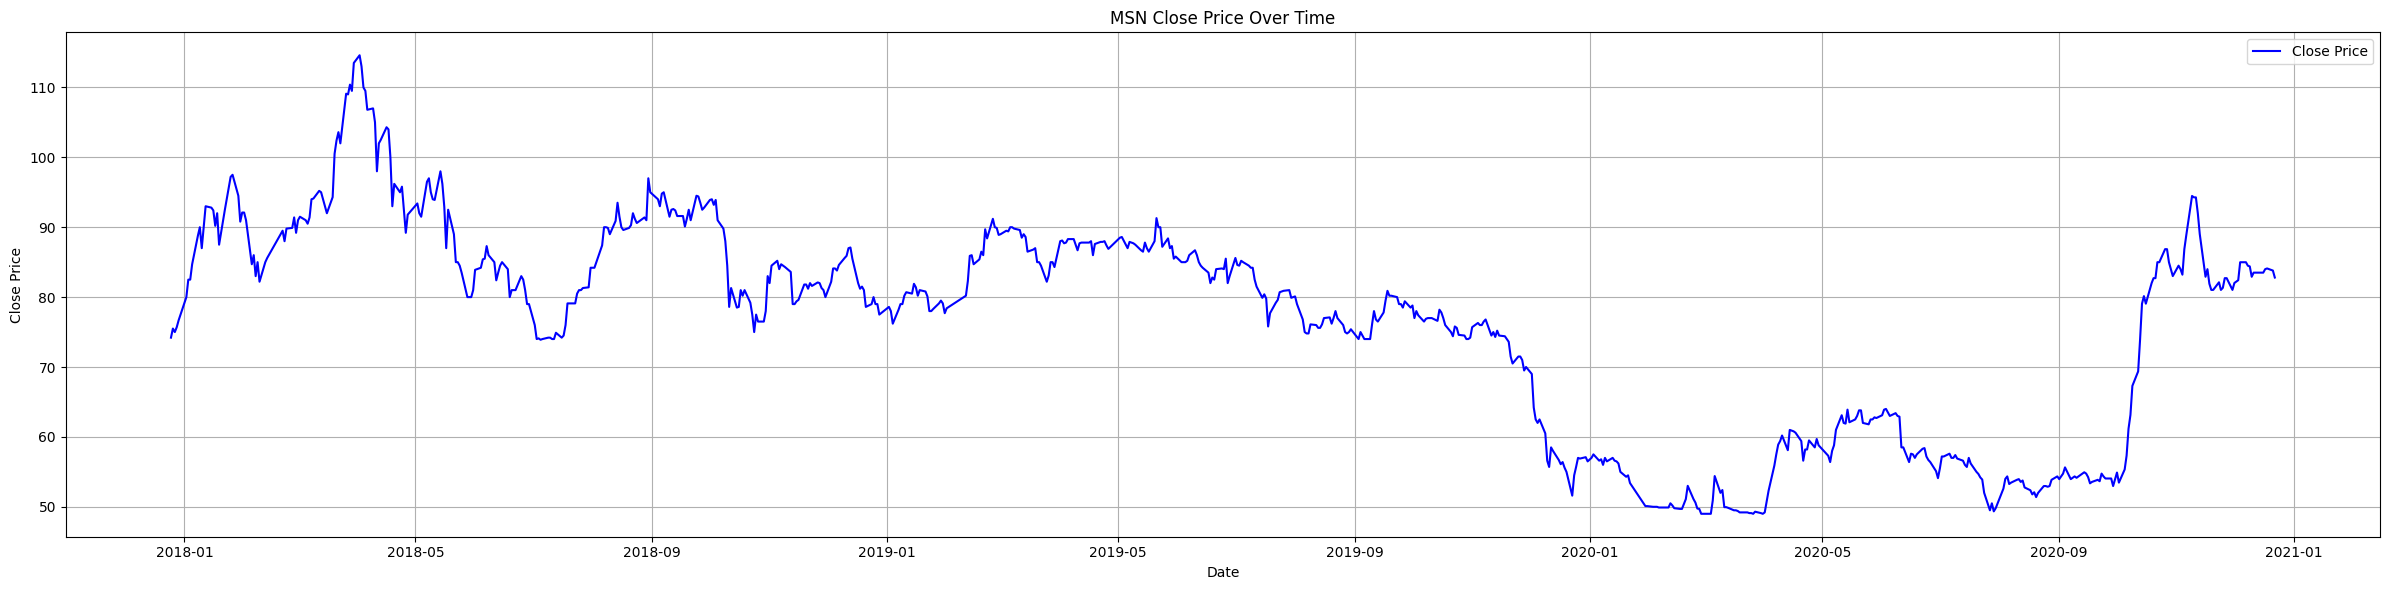

In [10]:
plt.figure(figsize=(24, 6))
plt.plot(MSN['Date'], MSN['Close'], label='Close Price', color='blue')
plt.title('MSN Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Giá cổ phiếu MSN nhìn chung có xu hướng tăng ở giai đoạn đầu và đạt đỉnh ở ở mức hơn 110.000đ/cổ phiếu.
- Giai đoạn đầu năm 2020 có sự biến động mạnh, giá giảm từ gần 80.000đ/cổ phiếu xuống còn 50.000đ/cổ phiếu. Điều này có thể do tác động của đại dịch COVID-19.
- Tới cuối năm 2020, giá mới phục hồi về mức hơn 80.000đ/cổ phiếu.

## 3. Volume over time

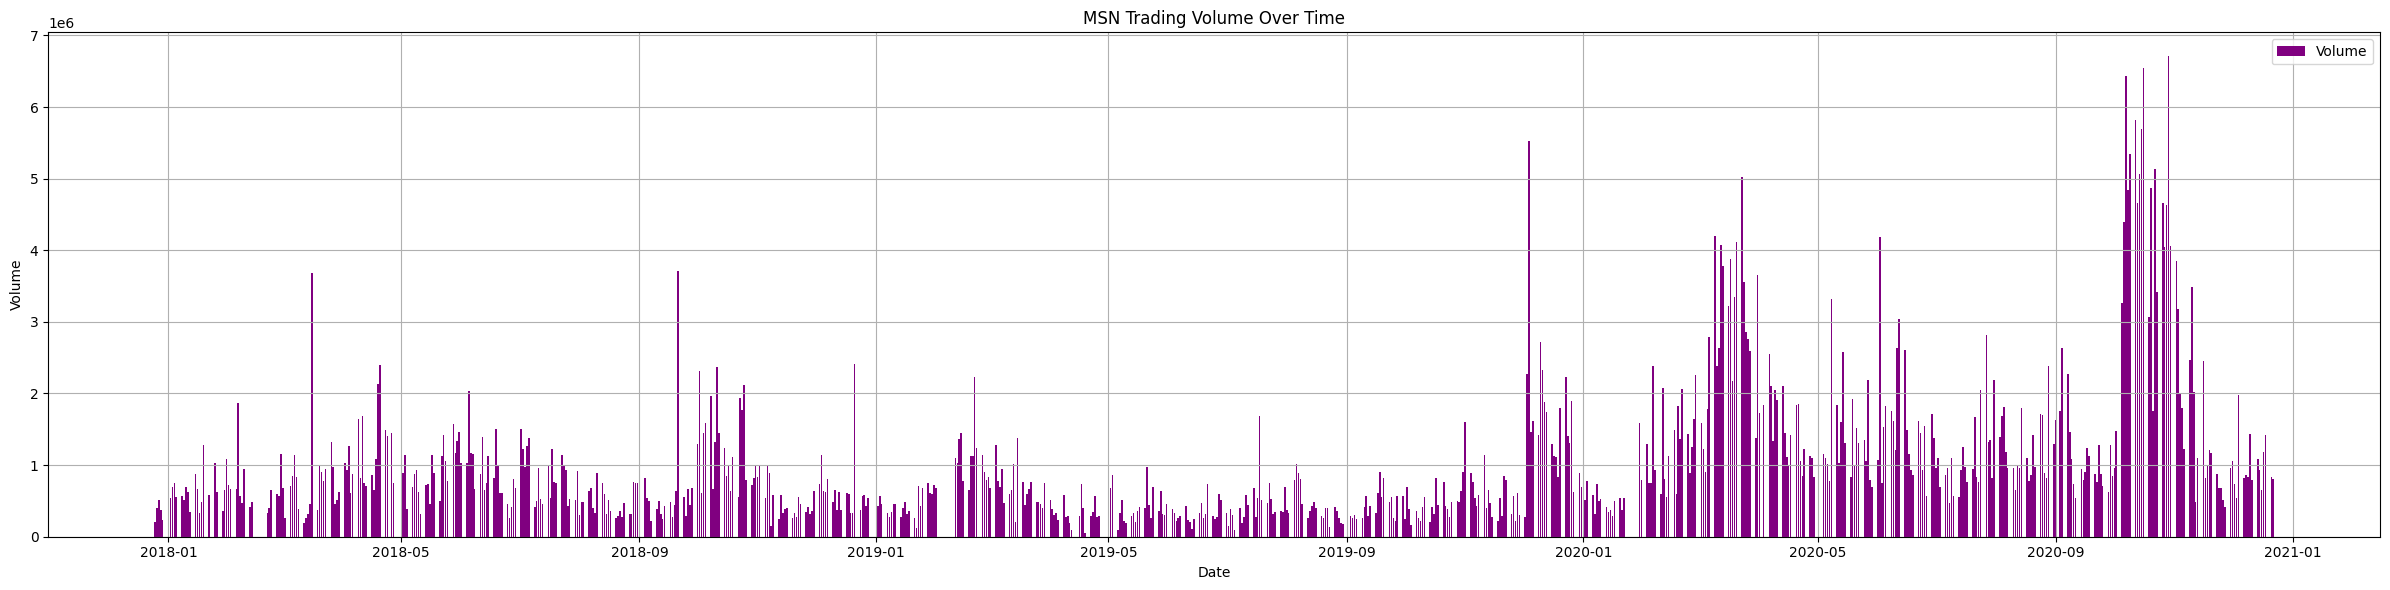

In [11]:
plt.figure(figsize=(24, 6))
plt.bar(MSN['Date'], MSN['Volume'], color='purple', label='Volume')
plt.title('MSN Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Volume có sự biến động mạnh và chênh lệch lớn giữa các ngày, do việc gộp dữ liệu ở trên.

## 4. Rate of return

In [12]:
from preprocessing import return_volatility_target

In [13]:
MSN = return_volatility_target(MSN)

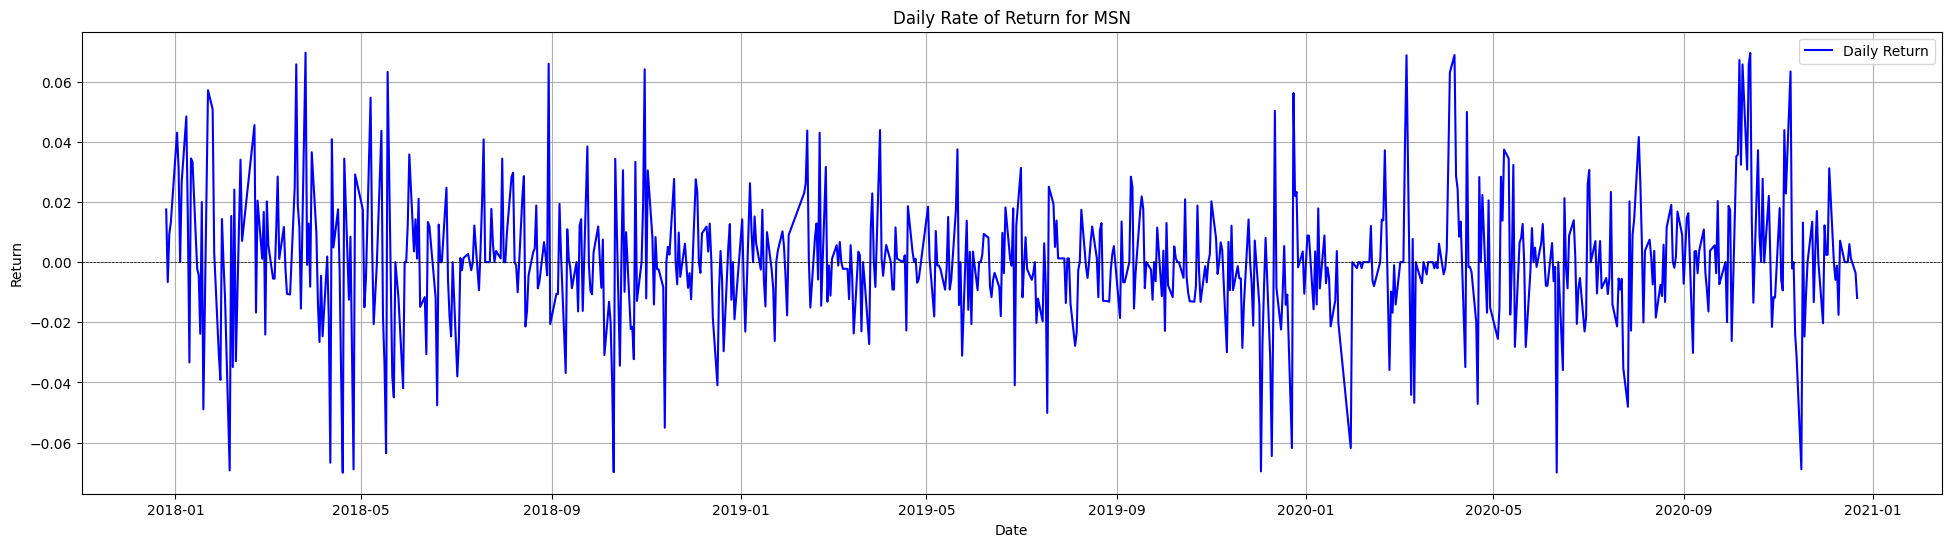

In [14]:
plt.figure(figsize=(24, 6))
plt.plot(MSN['Date'], MSN['Return'], label='Daily Return', color='blue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('Daily Rate of Return for MSN')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

- Tỷ suất sinh lời hàng ngày của cổ phiếu MSN dao động quanh mức 0, với nhiều biến động tăng giảm bất thường, đặc biệt là giai đoạn đầu 2020.
- Không có xu hướng rõ ràng. 

## 5. Volatility 

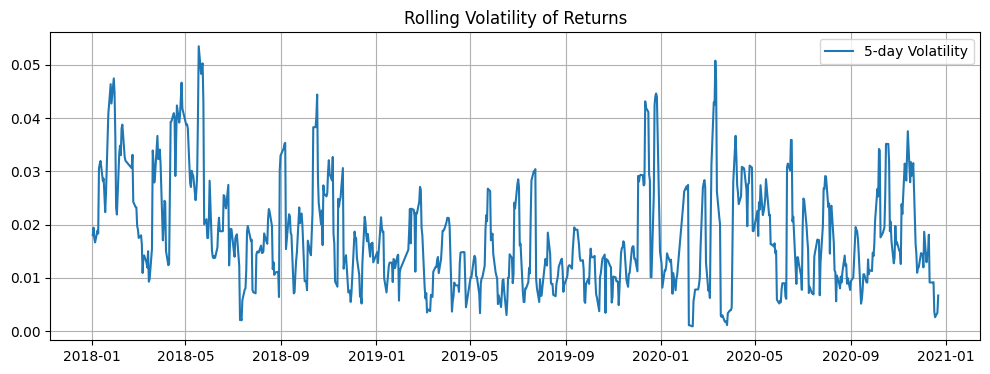

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(MSN['Date'], MSN['volatility_5'], label='5-day Volatility')
plt.title('Rolling Volatility of Returns')
plt.grid(True)
plt.legend()
plt.show()

- Rolling volatility tăng đột biến trong giai đoạn 2018, cso thời điểm vượt quá 5%, cho thấy mức độ biến động rất cao.
- Biến động giảm dần trong năm 2019, dao động chủ yếu dưới 2%. Nhưng lại chứng kiến nhiều đợt tăng vọt đột ngột ở năm 2020.

# III. Preprocessing data 

## 1. Removing Outliers 

In [16]:
from preprocessing import remove_outliers_and_plot

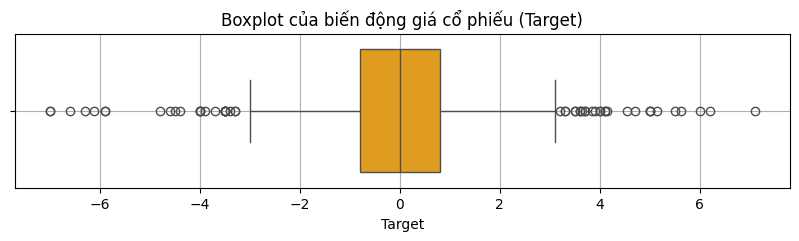

Số dòng còn lại sau khi loại outliers: 693


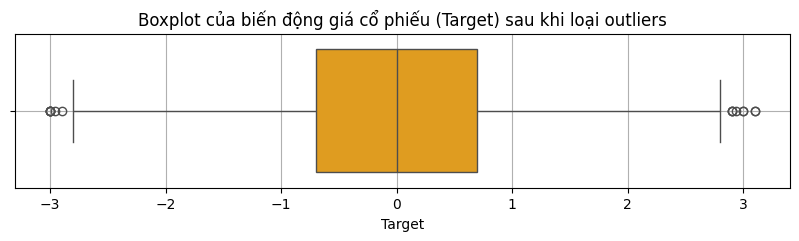

In [17]:
MSN = remove_outliers_and_plot(MSN)

- Thể hiện trên biểu đồ boxplot cho thấy có các giá trị outliers.
- Sau khi loại bỏ outliers, số lượng sample còn lại là 693.

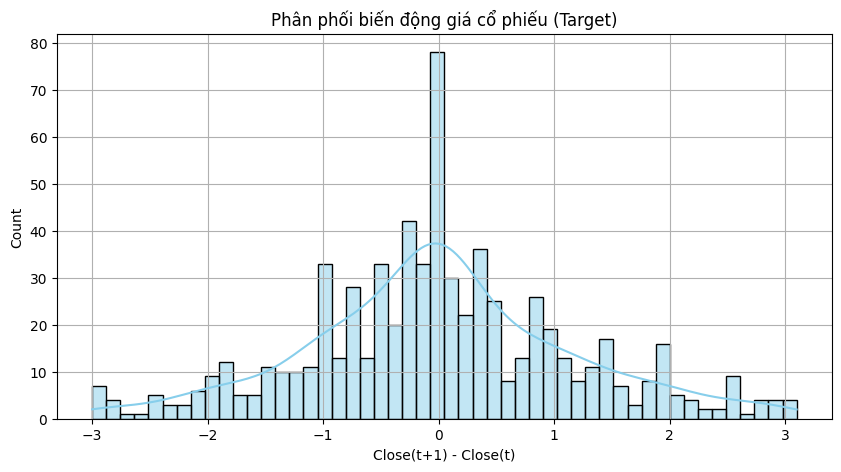

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(MSN['Target'], kde=True, bins=50, color='skyblue')
plt.title('Phân phối biến động giá cổ phiếu (Target)')
plt.xlabel('Close(t+1) - Close(t)')
plt.grid(True)
plt.show()

Sau khi xử lý loại bỏ outliers
- Distribution có dạng gần đối xứng quanh 0, với đỉnh nhọn tại trung tâm — cho thấy phần lớn biến động là nhỏ.
- Tuy nhiên, có đuôi dài hai bên, đặc biệt là bên trái, cho thấy sự hiện diện của một số biến động lớn bất thường (fat tails).

## 2. Features engineering

- Thêm các features mới 

In [19]:
from preprocessing import feature_engineering

In [20]:
MSN = feature_engineering(MSN)

## 3. Data segregation

- Sau khi xử lý xong, data sẽ được chia thành các train, validate, test set để tiến hành train và evaluate model.

In [21]:
from data_segregation import split_time_series_data

In [22]:
features, target, X_trainval, X_test, y_trainval, y_test = split_time_series_data(MSN)

- Kiểm tra lại shape của dataset trước khi vào bước train model.

In [23]:
X_trainval.shape

(534, 33)

In [24]:
X_test.shape

(134, 33)

In [25]:
y_trainval.shape

(534,)

In [26]:
y_test.shape

(134,)

# IV. Model

## 1. Training

- Sử dụng model LightGBM để predict chênh lệch giá.

In [27]:
from data_segregation import time_series_cv

In [28]:
cv_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbosity=-1)

val_scores, val_preds, val_trues, val_dates = time_series_cv(
    model=cv_model,
    X=X_trainval,
    y=y_trainval,
    dates=MSN, 
    n_splits=3
)

In [29]:
from visualization import plot_cv_predictions

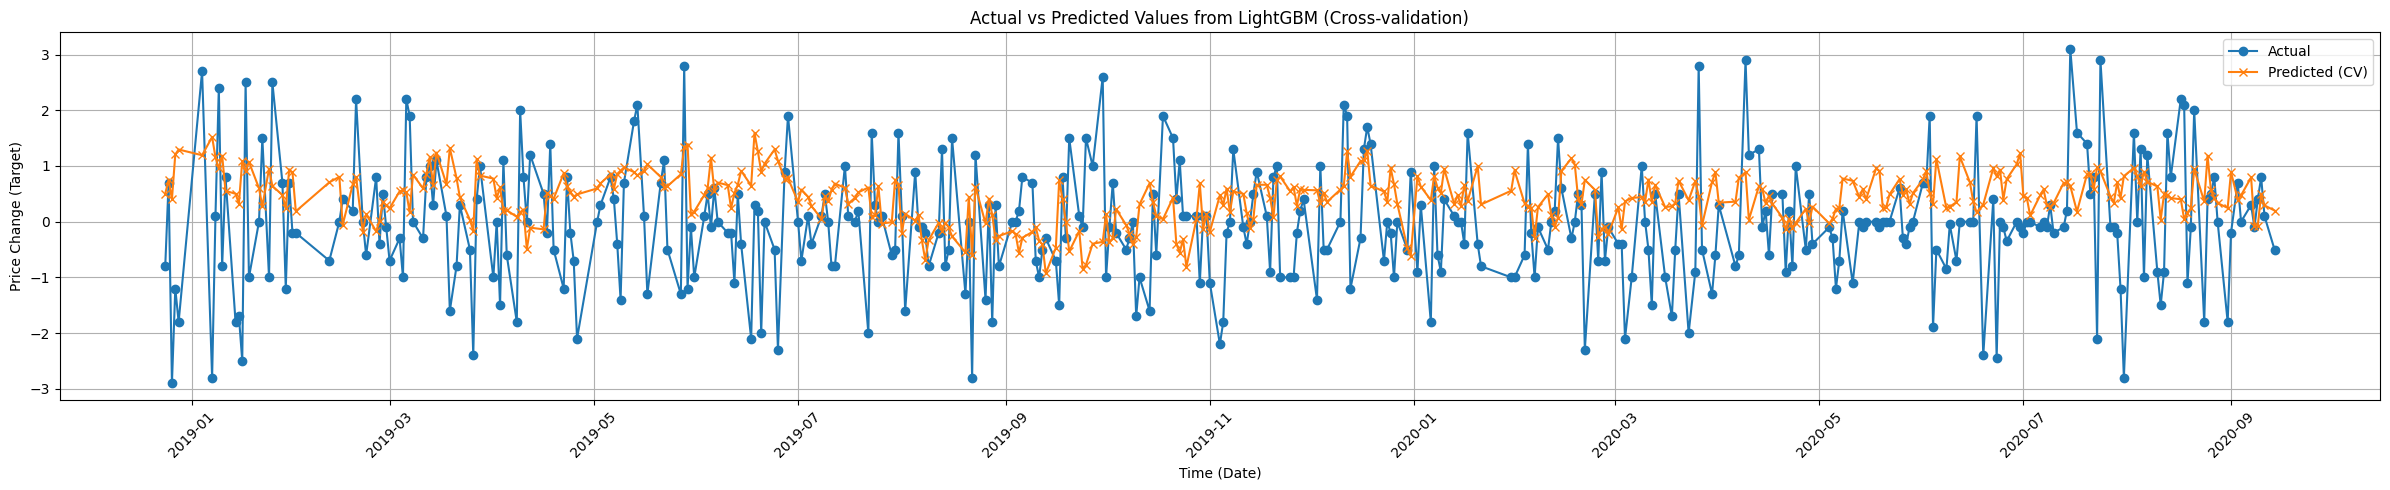

In [30]:
plot_cv_predictions(val_dates, val_trues, val_preds)

In [31]:
print(f"MAE trung bình (CV): {np.mean(val_scores):.4f}")

MAE trung bình (CV): 0.9761


- Dự đoán (đường cam) không phản ánh được các biến động mạnh và đột ngột của giá thực tế (đường xanh). Cho thấy model có thể đang gặp khó khăn trong việc học các dao động lớn hoặc bị bias về trung bình.
- MAE trên tập Cross-validation vào khoảng 0.9761 là khá lớn cho thấy model dự đoán chưa chính xác nhiều điẻm. 
- Có dấu hiệu của underfitting. 

## 2. Tunning 

- Sử dụng Optuna để tìm bộ hyper-parameters tối ưu.
- Kết quả tối ưu được đánh giá trên tập Cross-validation.

In [32]:
from tunning import optuna_objective

In [33]:
objective = optuna_objective(X_trainval, y_trainval, loss_type="rmse_corr", n_splits=3)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-05-10 17:18:25,103] A new study created in memory with name: no-name-96147485-0cd1-4322-a684-9dd6085a07cf
[I 2025-05-10 17:18:25,243] Trial 0 finished with value: 1.34077219693276 and parameters: {'n_estimators': 140, 'learning_rate': 0.08359724009650973, 'max_depth': 7, 'num_leaves': 42, 'min_child_samples': 20, 'subsample': 0.6514254439170385, 'colsample_bytree': 0.673924237564226}. Best is trial 0 with value: 1.34077219693276.
[I 2025-05-10 17:18:25,417] Trial 1 finished with value: 1.372732609446788 and parameters: {'n_estimators': 265, 'learning_rate': 0.08045146614112784, 'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 30, 'subsample': 0.770857102705414, 'colsample_bytree': 0.6379227795912586}. Best is trial 0 with value: 1.34077219693276.
[I 2025-05-10 17:18:25,527] Trial 2 finished with value: 1.3698695297926982 and parameters: {'n_estimators': 160, 'learning_rate': 0.13441956775051822, 'max_depth': 5, 'num_leaves': 63, 'min_child_samples': 29, 'subsample': 0.971

Best hyperparameters: {'n_estimators': 53, 'learning_rate': 0.010320572867878847, 'max_depth': 10, 'num_leaves': 58, 'min_child_samples': 20, 'subsample': 0.8054899438228705, 'colsample_bytree': 0.8946930540692682}


## 3. Retraining and fetures importance

- Model sẽ được train lại một lần nữa với toàn bộ tập train và bộ hyper-parameter tối ưu vừa tìm được. 

In [34]:
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_trainval, y_trainval)

y_pred_test = best_model.predict(X_test)

In [35]:
importances = best_model.feature_importances_
feat_names = features.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df.head(10))

           Feature  Importance
26    Volume_avg_5          78
4           Volume          74
27    Volume_spike          63
28  Intraday_range          58
5           Return          58
29   Open_to_Close          56
3            Close          51
23   Volatility_20          51
7     volatility_5          45
6         return_5          42


- Các features được thêm vào có vai trò khá quan trọng, khi model dựa nhiều vào các features này để đưa ra quyết định.
- Các features có đóng góp nhiều nhất gồm: Open_to_Close, Return, Intraday_range, Volume_avg_5, Volume_spike, Volatility_20, Volume, Close, volatility_5, return_5.

In [36]:
from visualization import plot_test_predictions

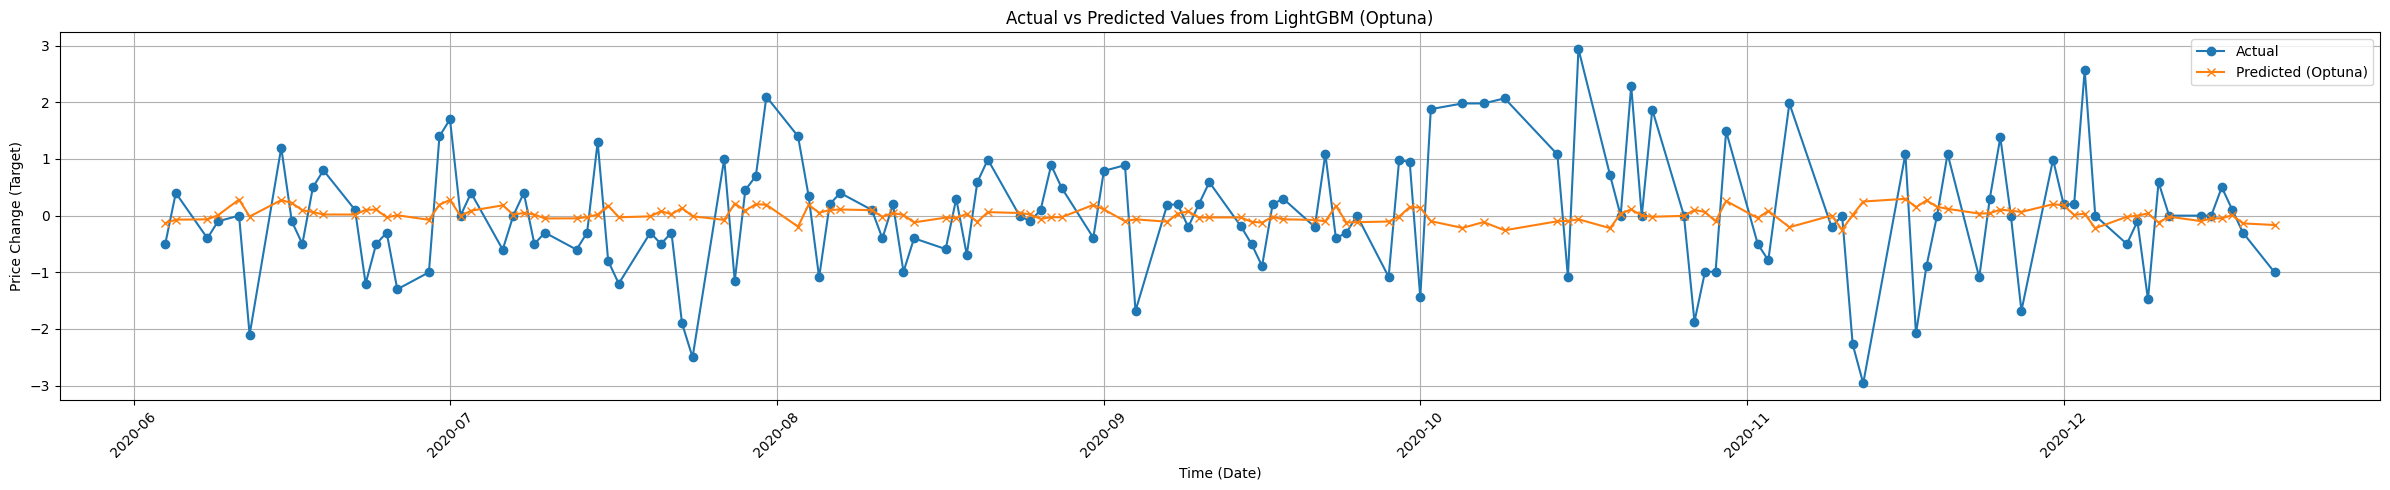

In [37]:
plot_test_predictions(MSN.loc[y_test.index, 'Date'].values, y_test.values, y_pred_test)

In [38]:
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print(f"[Final Result]")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

[Final Result]
MAE: 0.7973
RMSE: 1.0688


- Kết quả đánh giá MAE trên tập test là tốt hơn hẳn so với ở tập cross-validation tuy nhiên khả năng dự đoán biến động và bám sát các pattern lại kém hơn và bị làm mịn quá mức.